In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

dataset = pd.read_csv("development-activity-monitor.csv", header=0)
dataset.head()


In [104]:
dataset.shape

(1403, 42)

In [105]:

print(dataset.info())
print(dataset.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403 entries, 0 to 1402
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   data_format                  1403 non-null   object 
 1   development_key              1403 non-null   object 
 2   status                       1403 non-null   object 
 3   year_completed               1019 non-null   float64
 4   clue_small_area              1403 non-null   object 
 5   clue_block                   1403 non-null   int64  
 6   street_address               1403 non-null   object 
 7   property_id                  1403 non-null   int64  
 8   property_id_2                171 non-null    float64
 9   property_id_3                39 non-null     float64
 10  property_id_4                14 non-null     float64
 11  property_id_5                3 non-null      float64
 12  floors_above                 1403 non-null   int64  
 13  resi_dwellings    

In an initial analysis, I found 7 features of type object. delving into them i will:
DELETE: data_format, development_key(unique identifier), property_id (as is an unique identifier), property_id_2, property_id_3. property_id_4, property_id_5 as all of them are unique / unique identifiers and will have only noise impact on the analysis. the same will apply to street_address Will also delete geopoint as it just the representation of latitude and longitude.



In [106]:
dataset.drop(['data_format','development_key','property_id','property_id_2','property_id_3','property_id_4','property_id_5','geopoint','street_address','town_planning_application'],axis=1, inplace=True)

print(dataset.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403 entries, 0 to 1402
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   status                       1403 non-null   object 
 1   year_completed               1019 non-null   float64
 2   clue_small_area              1403 non-null   object 
 3   clue_block                   1403 non-null   int64  
 4   floors_above                 1403 non-null   int64  
 5   resi_dwellings               1403 non-null   int64  
 6   studio_dwe                   1403 non-null   int64  
 7   one_bdrm_dwe                 1403 non-null   int64  
 8   two_bdrm_dwe                 1403 non-null   int64  
 9   three_bdrm_dwe               1403 non-null   int64  
 10  student_apartments           1403 non-null   int64  
 11  student_beds                 1403 non-null   int64  
 12  student_accommodation_units  1403 non-null   int64  
 13  institutional_acco

Now let's convert the other types of data. Start with clue_small_area

In [107]:
print(dataset['status'].nunique())

4


In [108]:
dataset['status'] = pd.Categorical(dataset['status']).codes
dataset['status'].unique()

array([2, 0, 1, 3], dtype=int8)

Check if nulls

In [109]:
nan_count_per_column = dataset.isna().sum()
print(nan_count_per_column)

status                           0
year_completed                 384
clue_small_area                  0
clue_block                       0
floors_above                     0
resi_dwellings                   0
studio_dwe                       0
one_bdrm_dwe                     0
two_bdrm_dwe                     0
three_bdrm_dwe                   0
student_apartments               0
student_beds                     0
student_accommodation_units      0
institutional_accom_beds         0
hotel_rooms                      0
serviced_apartments              0
hotels_serviced_apartments       0
hostel_beds                      0
childcare_places                 0
office_flr                       0
retail_flr                       0
industrial_flr                   0
storage_flr                      0
education_flr                    0
hospital_flr                     0
recreation_flr                   0
publicdispaly_flr                0
community_flr                    0
car_spaces          

Year complete has 384 values... as an ASSUMPTION, I will consider the null values as the min value of the list. The reasoning is that probably the lack of data is due to unfamiliarity with the report system and data gathering that is more frequernt in the beginning of the data analysis proccess.

In [110]:
dataset['year_completed'].fillna(dataset['year_completed'].min(), inplace=True)
nan_count_per_column = dataset.isna().sum()
print(nan_count_per_column)

status                         0
year_completed                 0
clue_small_area                0
clue_block                     0
floors_above                   0
resi_dwellings                 0
studio_dwe                     0
one_bdrm_dwe                   0
two_bdrm_dwe                   0
three_bdrm_dwe                 0
student_apartments             0
student_beds                   0
student_accommodation_units    0
institutional_accom_beds       0
hotel_rooms                    0
serviced_apartments            0
hotels_serviced_apartments     0
hostel_beds                    0
childcare_places               0
office_flr                     0
retail_flr                     0
industrial_flr                 0
storage_flr                    0
education_flr                  0
hospital_flr                   0
recreation_flr                 0
publicdispaly_flr              0
community_flr                  0
car_spaces                     0
bike_spaces                    0
longitude 

In [111]:
from sklearn.preprocessing import LabelEncoder
##Encode the values for ground Truth:


# 1) We are interested in finding optimal number of groups for this dataset, where the ground truth grouping information is represented by `clue_small_area’ feature.

    ##  a) What method shall we use for solving this problem and why?
The method we are going to use to solve this problem is clustering. We want our model to be able to learn based on the information we are providing in wich region of melbourne the current development is being performed. Clustering is the ML model indicated for this kind of situation, where we want to be able to group points based on their features.

    ## b) Does this data suffer from curse of dimensionality? Explain.
    
The curse of dimensionality refers to the fact that as the number of features (or dimensions) grows, the amount of data we need to generalize accurately grows exponentially. Given our data, 'data_format','development_key','property_id','property_id_2','property_id_3','property_id_4','property_id_5','geopoint','street_address','town_planning_application' were not useful for clustering, and were dropped to mitigate the issue, so Yes, it did suffer, and we tried to mitigate the problem by analysing the features, checking the 


    ##  c) Find out optimal number of groups, report the outcome and justify your findings.
As shown below, we applied the elbow method from the KMeans++ algorithm. The solution we got gave us a total of 8 groups. As we have per the question a reference of the ground truth, it gives us a notion of the number of groups for us to cluster.  


In [133]:
correlation_matrix = dataset.corr()
print(correlation_matrix)

                            status  year_completed  clue_block  floors_above  \
status                    1.000000        0.388121   -0.089036     -0.095649   
year_completed            0.388121        1.000000   -0.082521      0.047153   
clue_block               -0.089036       -0.082521    1.000000     -0.125592   
floors_above             -0.095649        0.047153   -0.125592      1.000000   
resi_dwellings           -0.021860        0.086597    0.029270      0.731011   
studio_dwe               -0.081825       -0.060854    0.107910      0.116303   
one_bdrm_dwe             -0.059329        0.132541    0.024498      0.606331   
two_bdrm_dwe             -0.055879        0.141022    0.039057      0.658096   
three_bdrm_dwe           -0.075605        0.033516    0.069741      0.457234   
student_beds              0.007411        0.131409   -0.098160      0.115351   
institutional_accom_beds  0.020983        0.012260   -0.004691     -0.027533   
hotel_rooms              -0.094088      

In [134]:
correlations = correlation_matrix.unstack()

# Filter out self-correlation (diagonal elements) 
correlations = correlations[correlations != 1.0]
correlations = correlations.sort_index(level=[0,1])
correlations = correlations[::2]
# Sort by absolute value
sorted_correlations = correlations.abs().sort_values(ascending=False)
# Display pairs with the highest absolute correlation
print(sorted_correlations.head())

two_bdrm_dwe    resi_dwellings    0.831849
one_bdrm_dwe    two_bdrm_dwe      0.811838
                resi_dwellings    0.807297
resi_dwellings  floors_above      0.731011
two_bdrm_dwe    floors_above      0.658096
dtype: float64


Based on this data, hotel_rooms and hotel_serviced_apartents, student_beds and student apartments are too correlated, generating duplicated data. Lets fix this by dropping some of those.


In [135]:
dataset.drop(columns=["hotels_serviced_apartments","student_accommodation_units", "student_apartments"],axis=1, inplace=True)

KeyError: "['hotels_serviced_apartments', 'student_accommodation_units', 'student_apartments'] not found in axis"

In [136]:
dataset.head()

,status,year_completed,clue_small_area,clue_block,floors_above,resi_dwellings,studio_dwe,one_bdrm_dwe,two_bdrm_dwe,three_bdrm_dwe,...,storage_flr,education_flr,hospital_flr,recreation_flr,publicdispaly_flr,community_flr,car_spaces,bike_spaces,longitude,latitude
0,2,2006.0,North Melbourne,342,2,17,0,0,0,0,...,0,0,0,0,0,0,0,0,144.945030,-37.802822
1,2,2005.0,North Melbourne,333,3,12,0,0,0,0,...,0,0,0,0,0,0,0,0,144.945947,-37.802049
2,2,2013.0,West Melbourne (Residential),414,4,3,0,0,0,3,...,0,0,0,0,0,0,0,0,144.944719,-37.806791
3,2,2014.0,West Melbourne (Residential),409,3,28,0,17,11,0,...,0,0,0,0,0,0,0,28,144.942096,-37.806072
4,2,2007.0,North Melbourne,1012,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,144.939286,-37.800374


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

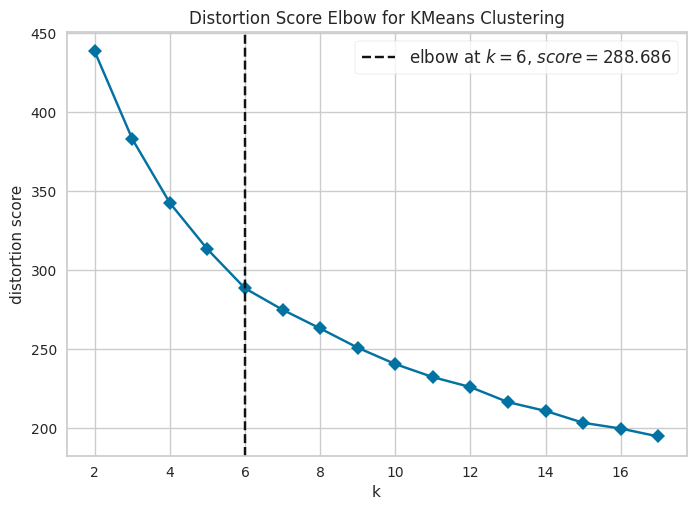

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [138]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler as Scaler 
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding
one_hot_encoder = OneHotEncoder(sparse=False)
encoded = one_hot_encoder.fit_transform(dataset[["clue_small_area"]])
encoded_df = pd.DataFrame(encoded, columns=one_hot_encoder.get_feature_names_out(['clue_small_area']))

# Drop the original column and concatenate the encoded DataFrame
X = dataset.drop(columns=["clue_small_area"])
# Normalize
scaler = Scaler()
X_scaled = scaler.fit_transform(X)
X = pd.concat([X, encoded_df], axis=1)



# KMeans and visualization
model = KMeans(init='k-means++', random_state=13)
visualiser = KElbowVisualizer(model, k=(2,18), metric="distortion", timings=False)
visualiser.fit(X_scaled)
visualiser.show()

In [129]:
kmeans_= KMeans(init='k-means++', random_state=13, n_clusters=11)

2) Implement two alternative solutions of Q1 (c), except Kmeans/Kmeans++ and Shape-based clustering. Compare and report the findings.


Will start with a hierarchical clustering. FOr this one, we should use dendograms to identify the optimal number of clusters: 

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

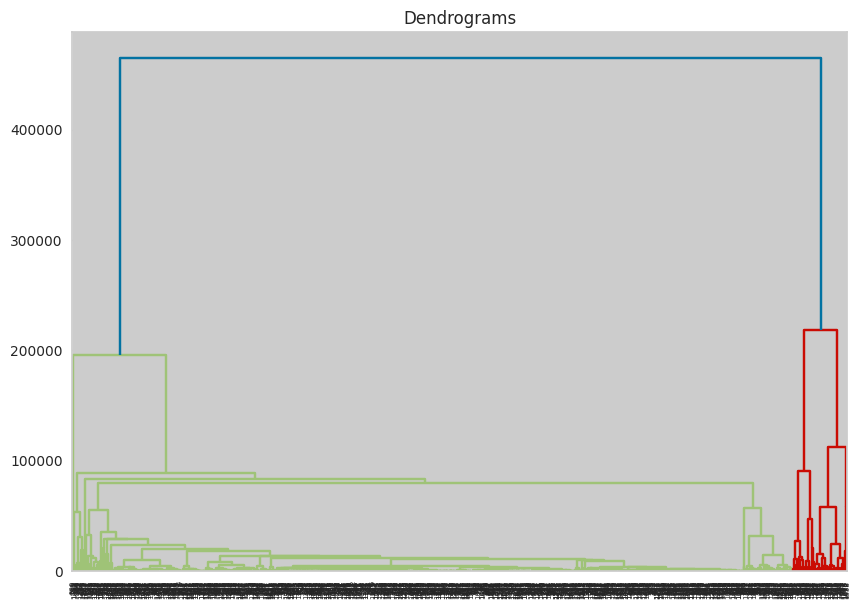

In [131]:
# Dendogram for Heirarchical Clustering
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

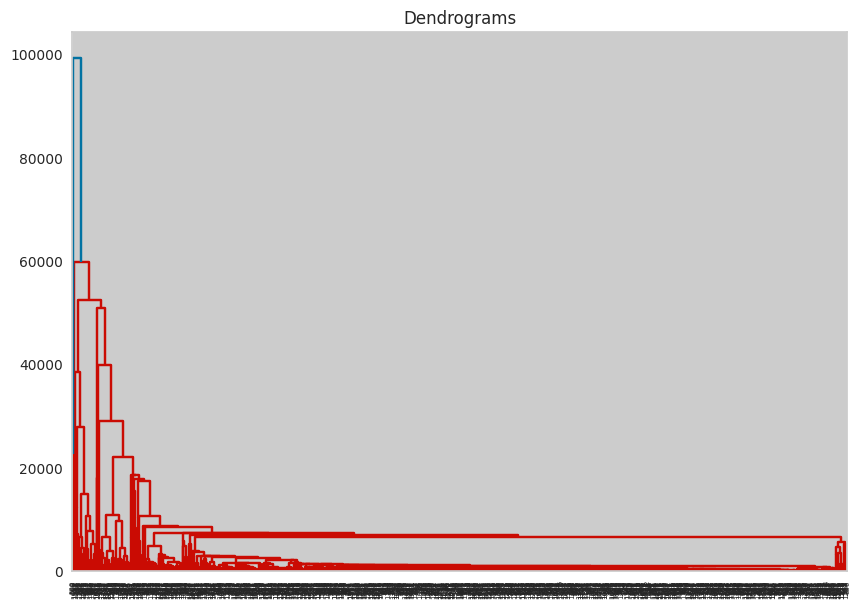

In [132]:
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='average'))

For the Hierarchical clustering, we used 2 different calculations to find the best number of clusters. the first using the ward linkage on a condensed distance matrix, and that gave us 5 clusters. On the second we used the average method to calculate the optimal number of groups, and got 2.


3) Implement two alternative solutions of Q1 (c) using Shape-based clustering. Compare and report the findings.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

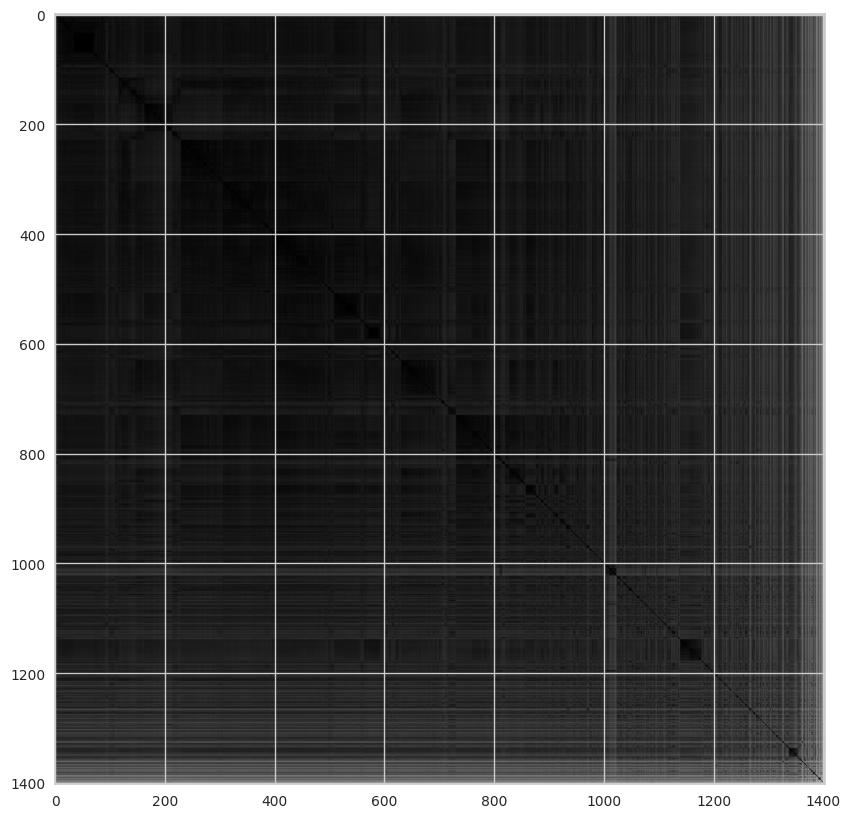

In [76]:
from pyclustertend import vat, ivat
from sklearn.preprocessing import scale

X1 = scale(X)
vat (X1)





findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

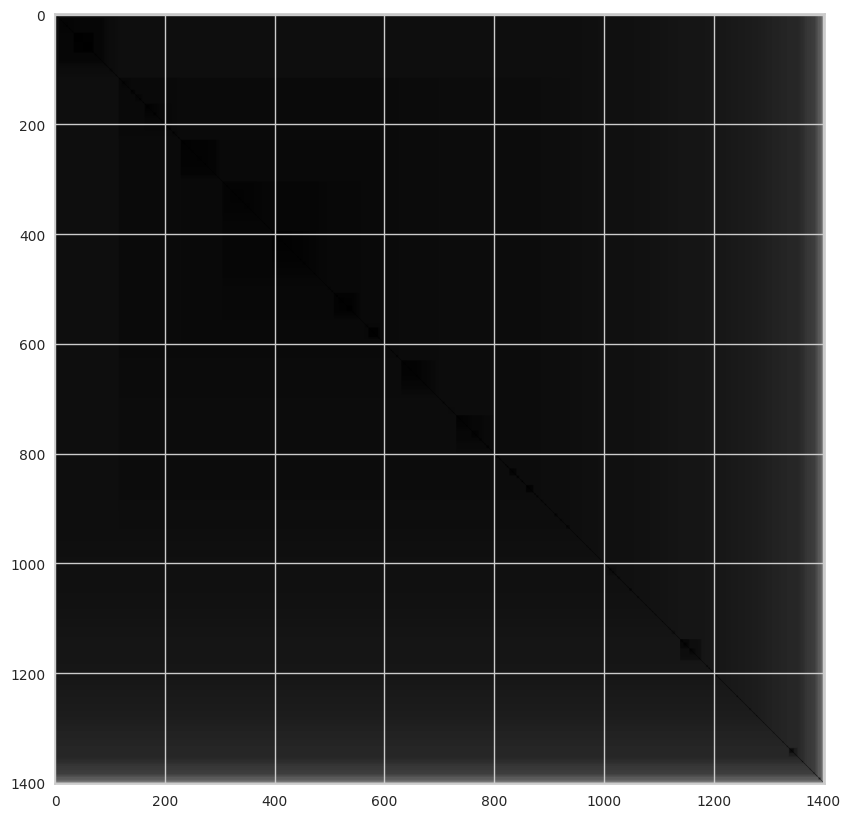

In [77]:
ivat(X1)

4) Evaluate quality of the groupings that you have reported as a solution of Q1 (c), Q2 and Q3. Based on the evaluation outcomes, report the best solution and explain the results.


In [ ]:
import numpy as np
from sklearn import metrics
kmeans = KMeans(n_clusters=22)
kmeans.fit(X)

y_true = gt.to_numpy()
y_pred = kmeans.fit_predict(X)




def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

print(
    "purity_score for k-means with 22 clusters: %0.3f"
    % purity_score(y_true, y_pred)
)


In [ ]:
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage
linked = linkage(X, method='ward')
y_pred = fcluster(linked, t=5, criterion='maxclust')
print(
    "purity_score for hyerarchical-ward with 5 clusters: %0.3f"
    % purity_score(y_true, y_pred))




In [ ]:
linked = linkage(X, method='average')
y_pred = fcluster(linked, t=5, criterion='maxclust')
print(
    "purity_score for hyerarchical-average with 5 clusters: %0.3f"
    % purity_score(y_true, y_pred))


In our comparison, to measure the quality of each method, we used the purity score for each implementation. For Kmeans, the purity score was 0.322 (32% accuracy), for hyerarchical-ward, we got 0.242 (24%) and for  hyerarchical-average, we got 0.239 (also 24%). VAT and iVAT, are algorithms to visualise grouping trends, and have no grouping ou prediction implementation. In our case, the data density and sparsity was too great to be able to clearly identify the trends.

# 5)  Quantify and print the relationship among independent variables of this dataset (development-activity-monitor.csv). Calculate three collective variables, using two different approaches: i) except PCA and ii) using UMAP, that represent the same dataset. Create two three-dimensional plots to display the relationship between these new variables and explain the plot.

In [ ]:
correlation_matrix = dataset.corr()
print(correlation_matrix)

In [ ]:
correlations = correlation_matrix.unstack()

# Filter out self-correlation (diagonal elements) 
correlations = correlations[correlations != 1.0]
correlations = correlations.sort_index(level=[0,1])
correlations = correlations[::2]
# Sort by absolute value
sorted_correlations = correlations.abs().sort_values(ascending=False)

# Display pairs with the highest absolute correlation
print(sorted_correlations.head())

In [ ]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

tsne = TSNE(n_components=3, perplexity=30, random_state=42)  
data_tsne = tsne.fit_transform(X1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_tsne[:, 0], data_tsne[:, 1], data_tsne[:, 2])
ax.set_xlabel('t-SNE C 1')
ax.set_ylabel('t-SNE C 2')
ax.set_zlabel('t-SNE C 3')
ax.set_title('3D t-SNE Visualization')
plt.show()

In [ ]:
import umap
reducer = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)  # 2D reduction
data_umap = reducer.fit_transform(X1)
# Assuming you've done 3D UMAP reduction as data_umap_3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_umap[:, 0], data_umap[:, 1], data_umap[:, 2])
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
ax.set_title('3D UMAP Visualization')
plt.show()

# 6) Is there any loss of information due to the transformation performed in Q4? Explain your answer with evidence.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(data_umap, X1)
# Reconstruct original data from reduced data
data_reconstructed = knn.predict(data_umap)
# Calculate reconstruction error for UMAP
reconstruction_error_umap = mean_squared_error(X1, data_reconstructed)
print(reconstruction_error_umap)

In [ ]:
data_reconstructed = knn.predict(data_tsne)
reconstruction_error_umap = mean_squared_error(X1, data_reconstructed)
print(reconstruction_error_umap)

For non-linear methods like t-SNE and UMAP, there's no direct way to compute precision loss, so I applied the reduction on the dataset with the 2 different methods, and subsequently run a k-nn regressor to predict the original data points. after that, I ran a mean squared error comparing the actuals with the calculation... that generates an error calculation direcly relative to the results for the original dataset mean values. In our experience, the UMAP reductio was ABSURDLY better than the tsne data. TNSE gave us 4.5355 as the square mean error rate and the UMAP gave us only 0.198